# Курс аналитик данных на Python
## Модуль 8.2 Алгоритмы кластеризации

In [16]:
import pandas as pd
import numpy as np
from datetime import date,datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('../data/consumer_data.csv',encoding='cp1251',parse_dates=['InvoiceDate'])
df.drop(df[df['CustomerID'].isna()].index,inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


<img src="../img/sklearn_clusterisation.png" alt="hop hop loshok" width="1000">

А по ссылке можно посмотреть базовые преимущества и недостатки методов кластеризации <br>
https://scikit-learn.org/stable/modules/clustering.html

In [19]:
df_user_product = df.groupby(['CustomerID','StockCode']).agg({
    'Quantity':sum
}).unstack(1).fillna(0)

In [20]:
df_user_product.head()

Quantity                                                           \
StockCode     10002 10080 10120 10123C 10124A 10124G 10125 10133 10135 11001   
CustomerID                                                                     
12346           0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
12347           0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
12348           0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
12349           0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
12350           0.0   0.0   0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   

            ...                                                                
StockCode   ... 90214Y 90214Z BANK CHARGES   C2 CRUK    D  DOT    M PADS POST  
CustomerID  ...                                                                
12346       ...    0.0    0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
12347       ...    0.0    0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
12348       ...    0.0    0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0  9.0  
12349       ...    0.0    0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
12350       ...    0.0    0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 3684 columns]

Для того, чтобы понять разбиваются ли пользователи на группы, можно использовать TSNE (попытка сократить размерность, сохранив всю информацию). То есть представить многомерную матрицу, ужав размерность до 2

In [21]:
tsne = TSNE()
transformed = tsne.fit_transform(df_user_product)

In [22]:
df_user_product.shape

(4372, 3684)

In [23]:
transformed.shape

(4372, 2)

Была размерность 3684, после преобразования TSNE стала 2. Значит, это можно теперь изобразить на диаграмме

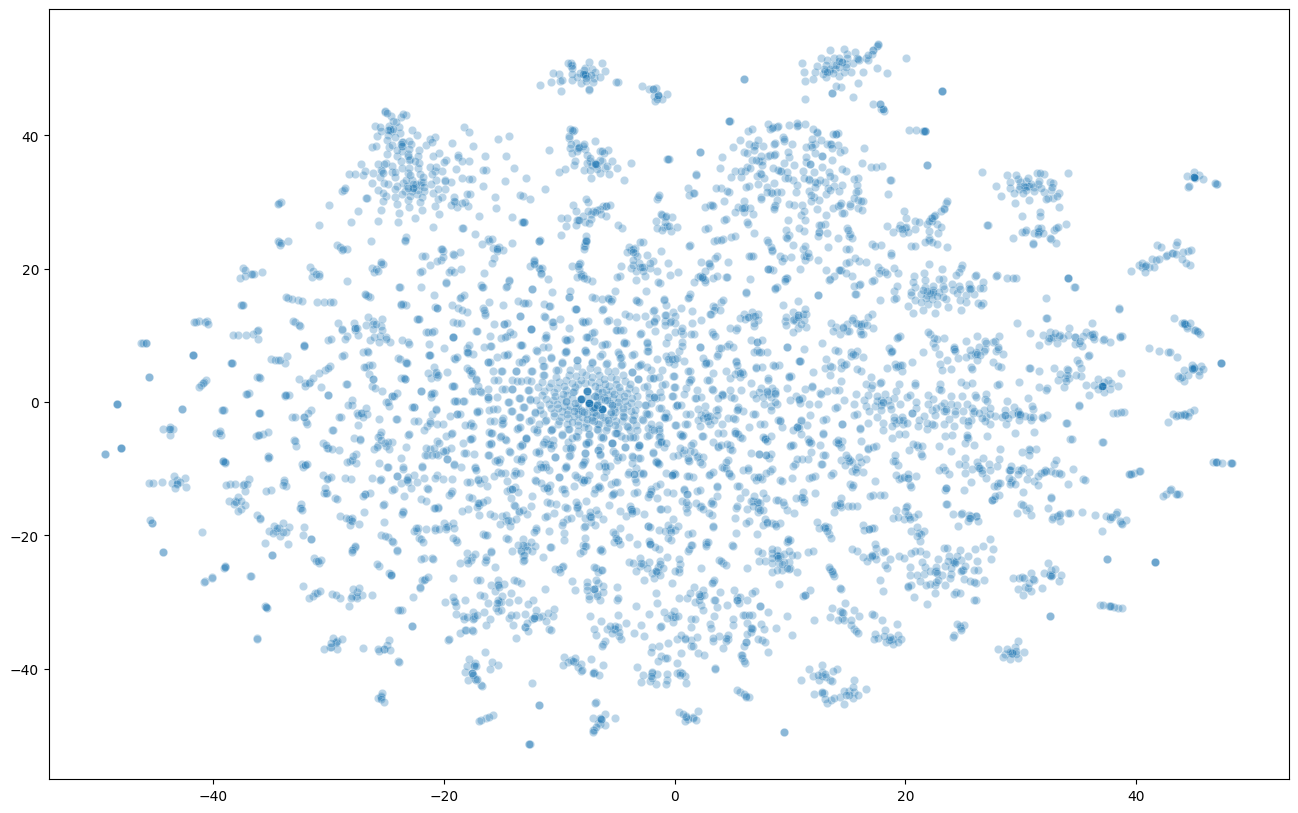

In [24]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=transformed[:,0],y=transformed[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
);

Нормируем изначальный массив данных

In [25]:
X_user_products_tfidf = TfidfTransformer().fit_transform(df_user_product.values)

In [26]:
X_user_products_tfidf.shape

(4372, 3684)

Снова применяем TSNE

In [27]:
X_user_products_tfidf_transformed = tsne.fit_transform(X_user_products_tfidf.toarray())

И строим диаграмму

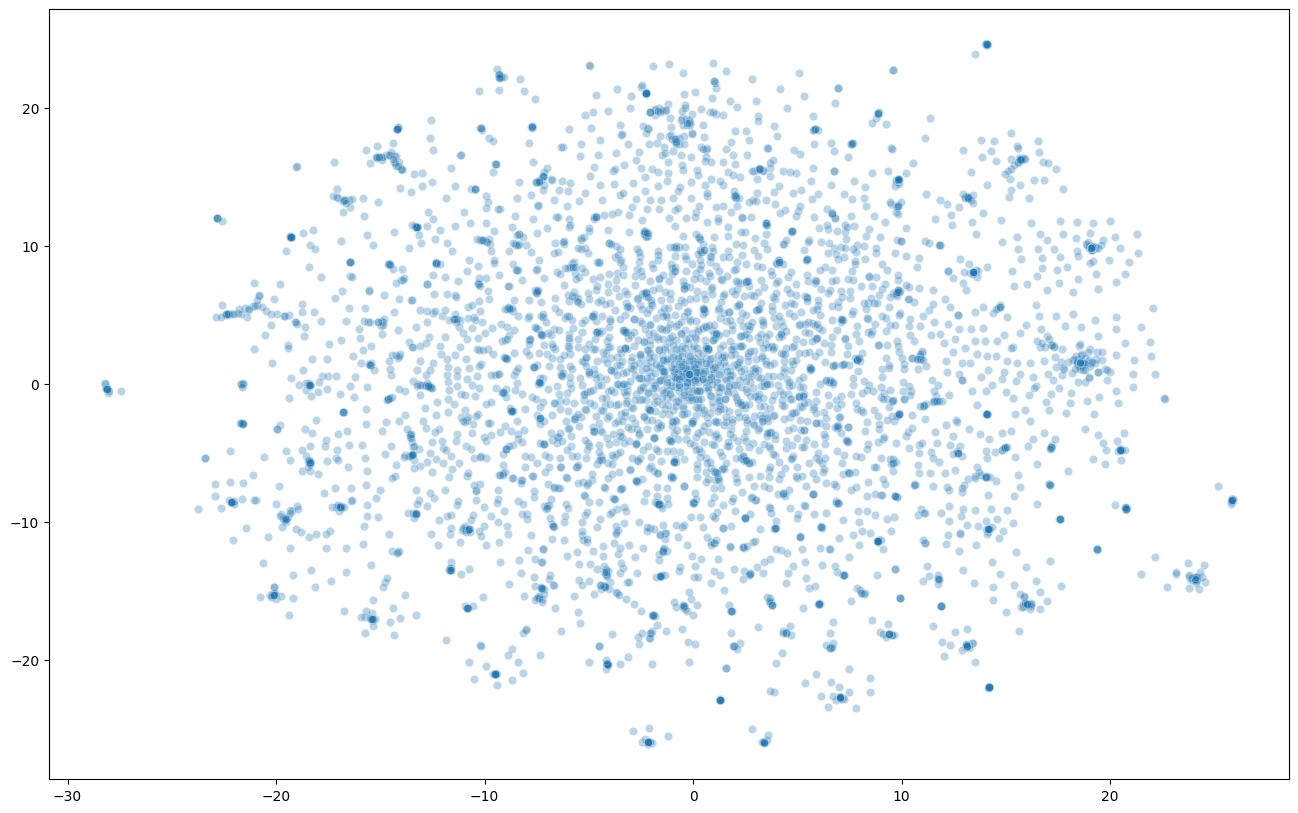

In [28]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_user_products_tfidf_transformed[:,0],y=X_user_products_tfidf_transformed[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
);

Даже с такой поправкой, тоже всё разбивается

---
Например еще можно сгруппировать товары, это может понадобится например для составления переменной менее шумящей.  
Сгруппируем товары по описанию и посмотрим насколько часто это описание встречается

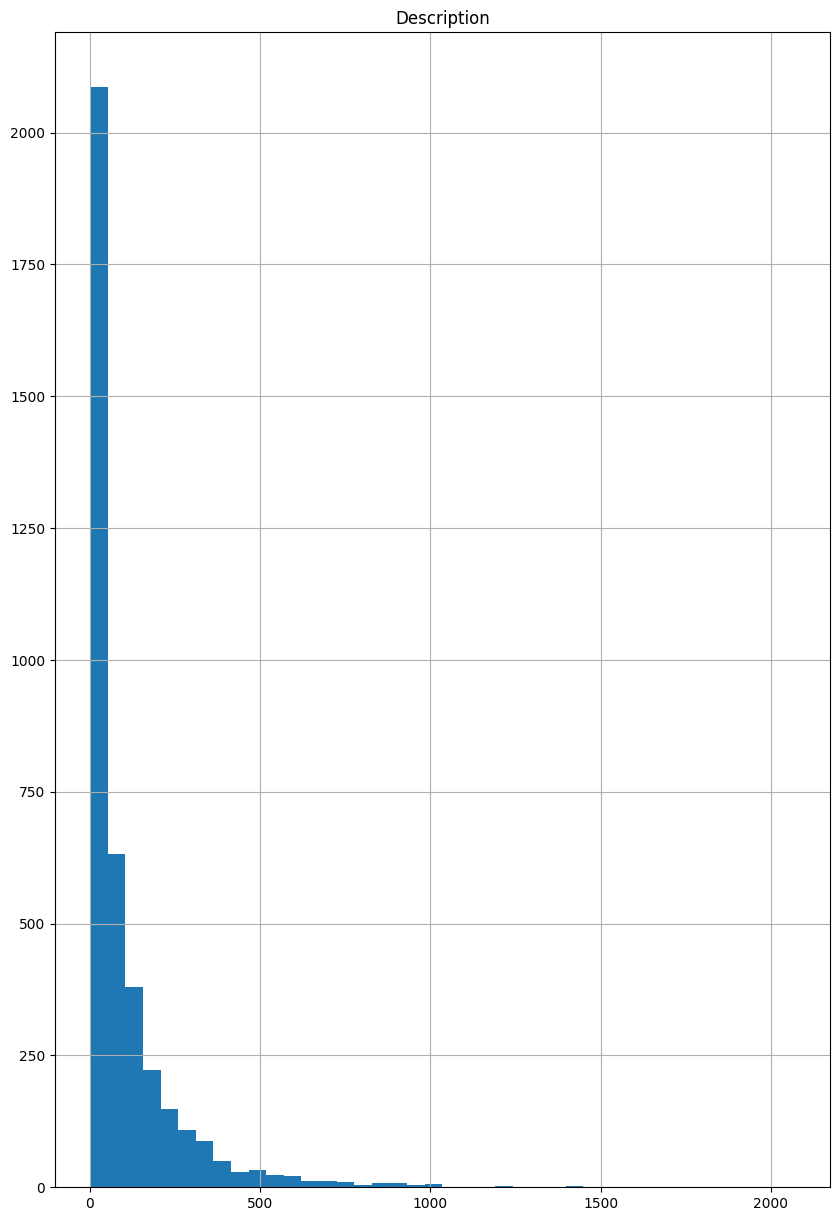

In [29]:
df.groupby('Description').agg({
    'Description':'count'
}).hist(bins=40);

Получили очень длинный правый хвост, значит такая метрика будет "шуметь", то есть по некоторым товарам мало данных. Это можно решить группировкой товаров с помощью кластеризации.

In [31]:
products = df['Description'].unique()

In [32]:
products.shape

(3896,)

In [33]:
products[0]

'WHITE HANGING HEART T-LIGHT HOLDER'

Векторизируем их с помощью Tdidf

In [34]:
vectorizer = TfidfVectorizer()  # max min document frequency
X = vectorizer.fit_transform(products)

In [35]:
X.shape

(3896, 2039)

In [36]:
print(X[0])

  (0, 915)	0.4621398298527657
  (0, 1059)	0.4657076959944732
  (0, 889)	0.389308183291721
  (0, 877)	0.4742203422029826
  (0, 1999)	0.43942840715884757


In [37]:
vectorizer.vocabulary_

{'white': 1999,
 'hanging': 877,
 'heart': 889,
 'light': 1059,
 'holder': 915,
 'metal': 1146,
 'lantern': 1028,
 'cream': 495,
 'cupid': 517,
 'hearts': 890,
 'coat': 435,
 'hanger': 875,
 'knitted': 1012,
 'union': 1949,
 'flag': 710,
 'hot': 929,
 'water': 1988,
 'bottle': 228,
 'red': 1515,
 'woolly': 2023,
 'hottie': 930,
 'set': 1627,
 'babushka': 108,
 'nesting': 1235,
 'boxes': 239,
 'glass': 823,
 'star': 1757,
 'frosted': 773,
 'hand': 872,
 'warmer': 1981,
 'jack': 963,
 'polka': 1425,
 'dot': 599,
 'assorted': 104,
 'colour': 445,
 'bird': 185,
 'ornament': 1290,
 'poppy': 1441,
 'playhouse': 1414,
 'bedroom': 164,
 'kitchen': 1004,
 'feltcraft': 694,
 'princess': 1466,
 'charlotte': 366,
 'doll': 585,
 'ivory': 961,
 'mug': 1205,
 'cosy': 475,
 'box': 237,
 'of': 1265,
 'teaspoons': 1853,
 'vintage': 1970,
 'jigsaw': 980,
 'blocks': 203,
 'alphabet': 73,
 'home': 920,
 'building': 264,
 'block': 202,
 'word': 2024,
 'love': 1087,
 'recipe': 1508,
 'with': 2016,
 'doormat'

In [38]:
products[0]

'WHITE HANGING HEART T-LIGHT HOLDER'

То есть нулевое слово имеет индекс 1999 - white

## Попробуем сгруппировать с помощью dbscan

In [39]:
model = DBSCAN()  # eps=3, min_samples=2
clusters = model.fit_predict(X.toarray())

In [40]:
np.unique(clusters)

array([-1,  0,  1,  2,  3], dtype=int64)

Получилось 5 подгрупп. Посмотрим, что они из себя представляют

In [41]:
products[clusters == 1]

array(['NUMBER TILE COTTAGE GARDEN 8', 'NUMBER TILE COTTAGE GARDEN 9',
       'NUMBER TILE COTTAGE GARDEN 1', 'NUMBER TILE COTTAGE GARDEN 0 ',
       'NUMBER TILE COTTAGE GARDEN 6', 'NUMBER TILE COTTAGE GARDEN 2',
       'NUMBER TILE COTTAGE GARDEN 7', 'NUMBER TILE COTTAGE GARDEN 5',
       'NUMBER TILE COTTAGE GARDEN 4', 'NUMBER TILE COTTAGE GARDEN 3 '],
      dtype=object)

Получили, что сгруппировались по значениям, где меняются только цифры в конце описания. DBSCAN очень плохо работает с такими данными. Попробуем другой метод.

---
## Агломеративная кластеризация

In [42]:
model = AgglomerativeClustering(n_clusters=50, affinity='cosine', linkage='complete')
# affinity - метод кластеризации
preds = model.fit_predict(X.toarray())

In [43]:
np.unique(preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int64)

In [44]:
products[preds==4]

array(['5 STRAND GLASS NECKLACE CRYSTAL', 'BLACK+WHITE NECKLACE W TASSEL',
       '5 STRAND GLASS NECKLACE BLACK',
       'BLACK FINE BEAD NECKLACE W TASSEL',
       'PALE PINK/AMETHYST STONE NECKLACE',
       'TEAL/FUSCHIA COL BEAD NECKLACE',
       'AMBER FINE BEAD NECKLACE W TASSEL',
       '5 STRAND GLASS NECKLACE AMBER',
       'PURPLE AMETHYST NECKLACE W TASSEL',
       'RED KUKUI COCONUT SEED NECKLACE', 'PINK/AMETHYST/GOLD NECKLACE',
       'ORANGE/WHT/FUSCHIA STONES NECKLACE',
       'WHITE/PINK MINI CRYSTALS NECKLACE', "COTE D'AZURE NECKLACE",
       'LASER CUT MULTI STRAND NECKLACE',
       'BROWN KUKUI COCONUT SEED NECKLACE',
       'SPOTTED WHITE NATURAL SEED NECKLACE',
       'SILVER 2 STRAND NECKLACE-LEAF CHARM',
       '5 STRAND GLASS NECKLACE AMETHYST'], dtype=object)

Здесь разбиение имеет больше смысловую составляющую, но надо добавлять ручное разбиение. Попробуем другое разбиение.

---
## AffinityPropagation

In [45]:
model = AffinityPropagation()
preds = model.fit_predict(X.toarray())

In [46]:
np.unique(preds)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [47]:
products[preds == 701]

array(['WRAP MAGIC FOREST ', 'WALL ART THE MAGIC FOREST ',
       'WALL ART , THE MAGIC FOREST '], dtype=object)

AffinityPropagation разбил на 734 класса. Наполнение кластеров не так похоже как в DBSCAN. Не надо доразбивать вручную как при Агломеративной кластеризации

Вывод: это выглядит так, будто можно после применить это в жизни.
Лучше к таким метрикам относить как к Black Box. Это просто набор базовых методов, перебирать их до тех пор, пока нас не устроит результат